<a href="https://colab.research.google.com/github/Varun9213/SIIM-FISABIO-RSNA-COVID-19-Detection/blob/main/Effdet%5BTrain%5D%5BCovid%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade pip

     |████████████████████████████████| 1.6MB 13.8MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1


In [2]:
!pip install -q kaggle
!pip install albumentations==0.5.2 --no-cache-dir -q

     |████████████████████████████████| 72 kB 11.5 MB/s 
     |████████████████████████████████| 37.1 MB 1.3 MB/s 
     |████████████████████████████████| 948 kB 47.7 MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
!mkdir ~/.kaggle
!cp /content/gdrive/MyDrive/kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d sohomdey/siim-covid19-detection-512

 98% 801M/817M [00:15<00:00, 50.9MB/s]
100% 817M/817M [00:15<00:00, 56.7MB/s]


In [6]:
!mkdir train
!unzip -q /content/siim-covid19-detection-512.zip -d train

In [7]:
# !kaggle datasets download -d awsaf49/siimcovid19-512-jpg-image-dataset
# !mkdir train_512
# !unzip -q /content/siimcovid19-512-jpg-image-dataset.zip -d train_512

In [8]:
!kaggle datasets download -d kozodoi/timm-pytorch-image-models
!mkdir timm
!unzip -q /content/timm-pytorch-image-models.zip -d timm 

 63% 9.00M/14.2M [00:00<00:00, 13.8MB/s]
100% 14.2M/14.2M [00:00<00:00, 19.4MB/s]


In [9]:
!kaggle datasets download -d shonenkov/omegaconf
!kaggle datasets download -d varundutt9213/efficientdetpytorch
!kaggle datasets download -d kaushal2896/pycocotools

  0% 0.00/129k [00:00<?, ?B/s]
100% 129k/129k [00:00<00:00, 39.8MB/s]
  0% 0.00/133k [00:00<?, ?B/s]
100% 133k/133k [00:00<00:00, 49.0MB/s]
  0% 0.00/272k [00:00<?, ?B/s]
100% 272k/272k [00:00<00:00, 39.5MB/s]


In [10]:
!mkdir omegaconf
!mkdir efficientdetpytorch
!mkdir pycocotools
!unzip -q /content/omegaconf.zip -d omegaconf
!unzip -q /content/efficientdetpytorch.zip -d efficientdetpytorch
!unzip -q /content/pycocotools.zip -d pycocotools

In [1]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pylab import rcParams
import seaborn as sns
import torch

In [2]:
raw = pd.read_csv('/content/train/train.csv')
raw['n_boxes'] = raw.label.apply(lambda x: (len(x.split(" "))//6)-1)
raw = raw[raw['n_boxes']>0].reset_index()

class CFG:
    
    apex=False
    debug=False
    train=True
    cutmix = False
    target_size=1
    batch_size=6
    n_fold=2
    
    model_name='tf_efficientdet_d3'
    
    checkpoint=None

    output_dir=f'/content/gdrive/MyDrive/kaggle/EffDet_{model_name}_Fold_{n_fold}'
    
    #checkpoint="/content/gdrive/MyDrive/kaggle/EffDet_tf_efficientdet_d3_Fold_0/last-checkpoint.bin"
    
    size=512
    dim=640
    
    n_epochs=30
    
    lr=3e-4
    
    SchedulerClass = torch.optim.lr_scheduler.CosineAnnealingLR
    scheduler_params = dict( 
        T_max=int(1.5*n_epochs),
        eta_min=4e-5,
        last_epoch=-1
    )
    
    step_scheduler = True  # do scheduler.step after optimizer.step
    validation_scheduler = False
    
    verbose = True
    verbose_step = 1
    
    weight_decay=0
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    num_workers=4
    freeze=False
    
if CFG.debug:
    
    CFG.epochs = 1
    raw = raw.sample(n=100, random_state=CFG.seed).reset_index(drop=True)

In [3]:
# ====================================================
# Library
# ====================================================
import sys
sys.path.append('/content/timm/pytorch-image-models-master')

import os
import math
import time
from datetime import datetime
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial
from glob import glob

import cv2
from PIL import Image

import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau, LambdaLR
#from warmup_scheduler import GradualWarmupScheduler

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

from torch.cuda.amp import autocast, GradScaler

import warnings 
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Python        : ' + sys.version.split('\n')[0])
print('Numpy         : ' + np.__version__)
print('Pandas        : ' + pd.__version__)
print('PyTorch       : ' + torch.__version__)
print('Albumentations: ' + A.__version__)
print('Timm          : ' + timm.__version__)

Python        : 3.7.10 (default, May  3 2021, 02:48:31) 
Numpy         : 1.19.5
Pandas        : 1.1.5
PyTorch       : 1.9.0+cu102
Albumentations: 0.5.2
Timm          : 0.4.13


In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG.seed)

In [5]:
gkf  = GroupKFold(n_splits = 5)
raw['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(raw, groups = raw.id_image.tolist())):
    raw.loc[val_idx, 'fold'] = fold

In [6]:
marking=pd.DataFrame(columns=['image_id', 'width', 'height', 'x_min', 'y_min', 'x_max', 'y_max','fold'])
for _,row in tqdm(raw.iterrows()):
    bxs=np.array(row.label.split(" ")).reshape(-1,6)
    for bb in bxs:
        marking=marking.append({'image_id': row.id_image,
                                'width':row.width,
                                'height':row.height,
                                'x_min':np.clip((float(bb[2])/row.width), 0,1)*CFG.size,
                                'y_min':np.clip((float(bb[3])/row.height), 0,1)*CFG.size,
                                'x_max':np.clip((float(bb[4])/row.width), 0,1)*CFG.size,
                                'y_max':np.clip((float(bb[5])/row.height), 0,1)*CFG.size,
                                'fold':row.fold}, ignore_index=True)

In [7]:
raw.head()

,index,id_image,id_study,label,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,width,height,n_boxes,fold
0,0,000a312787f2,5776db0cec75,opacity 1 789.28836 582.43035 1815.94498 2499....,0,1,0,0,4256,3488,1,0
1,2,0012ff7358bc,9d514ce429a7,opacity 1 677.42216 197.97662 1545.21983 1197....,0,1,0,0,3056,2544,1,4
2,4,001bd15d1891,dfd9fdd85a3e,opacity 1 623.23328 1050 1337.23328 2156 opaci...,0,1,0,0,3408,2800,1,3
3,7,002e9b2128d0,0717c8ac304f,opacity 1 276.72917 627.42968 1187.31776 2283....,0,1,0,0,2872,2416,1,2
4,8,00326161e51e,a81050391441,opacity 1 542.96057 364.37257 1133.32317999999...,0,1,0,0,2836,2336,1,1


In [8]:
marking.head()

,image_id,width,height,x_min,y_min,x_max,y_max,fold
0,000a312787f2,4256,3488,94.951983,85.494363,218.459546,366.933324,0
1,000a312787f2,4256,3488,270.184912,86.782426,401.873528,345.358491,0
2,0012ff7358bc,3056,2544,113.494812,39.844351,258.884998,241.058367,4
3,0012ff7358bc,3056,2544,300.346076,81.016855,403.722384,323.403371,4
4,001bd15d1891,3408,2800,93.631291,192.000000,200.898897,394.240000,3


In [9]:
def get_train_transforms():
    return A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.75),
            A.RandomResizedCrop(CFG.dim,CFG.dim),
            A.Cutout(num_holes=5, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=CFG.dim, width=CFG.dim, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [10]:
TRAIN_ROOT_PATH = '/content/train/images'


class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        if self.test or not CFG.cutmix:
            image, boxes = self.load_image_and_boxes(index)
        else:
            if random.random() > 0.2 :
                image, boxes = self.load_image_and_boxes(index)
            else:
                image, boxes = self.load_cutmix_image_and_boxes(index, CFG.size)
        
        
        target = {}
        target['boxes'] = boxes
        target['image_id'] = torch.tensor([index])
        labels = torch.ones((target['boxes'].shape[0],), dtype=torch.int64)

        if self.transforms:
            
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    target['labels'] = torch.tensor(sample['labels'])
                    break
                    

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.png', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['image_id'] == image_id]
        boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values
        return image, boxes

    def load_cutmix_image_and_boxes(self, index, imsize):
        """ 
        This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        """
        w, h = imsize, imsize
        s = imsize // 2
    
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []

        for i, index in enumerate(indexes):
            image, boxes = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
        return result_image, result_boxes

In [11]:
train_dataset = DatasetRetriever(
    image_ids=np.unique(marking[marking['fold'] != CFG.n_fold].image_id.values),
    marking=marking,
    transforms=get_train_transforms(),
    test=False,
)

validation_dataset = DatasetRetriever(
    image_ids=np.unique(marking[marking['fold'] == CFG.n_fold].image_id.values),
    marking=marking,
    transforms=get_valid_transforms(),
    test=True,
)

torch.Size([2]) torch.Size([2, 4])


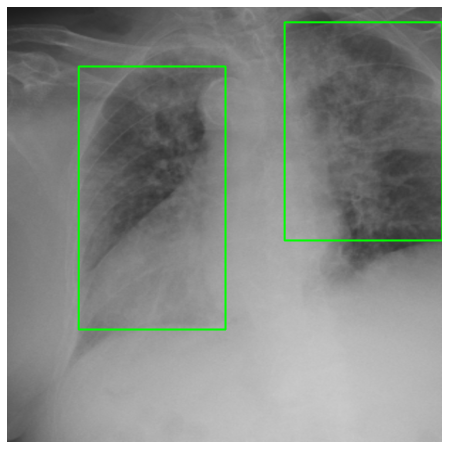

In [12]:
image, target, image_id = train_dataset[1]
boxes = target['boxes'].cpu().numpy().astype(np.int32)
print(target['labels'].shape, target['boxes'].shape)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

In [13]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count  

In [14]:
import warnings

warnings.filterwarnings("ignore")

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'{config.output_dir}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]
                target_res = {}
                target_res['bbox'] = boxes
                target_res['cls'] = labels 
                target_res["img_scale"] = torch.tensor([1.0] * batch_size, dtype=torch.float).to(self.device)
                target_res["img_size"] = torch.tensor([images[0].shape[-2:]] * batch_size, dtype=torch.float).to(self.device)

                output = self.model(images, target_res)
                loss = output['loss']
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        
        if CFG.apex:
            scaler = GradScaler()
            
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
                    
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            self.optimizer.zero_grad()
            
            if CFG.apex:
                with autocast():
                    loss = self.model(images, dict(bbox=boxes, cls=labels))['loss']
            else:
                loss = self.model(images, dict(bbox=boxes, cls=labels))['loss']
            
            if CFG.apex:
                scaler.scale(loss).backward()
            else:
                loss.backward()
                
            if CFG.apex:
                scaler.step(self.optimizer)
                scaler.update()
            else:
                self.optimizer.step()

            summary_loss.update(loss.detach().item(), batch_size)


            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [15]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run_training():
    device = torch.device('cuda:0')
    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=CFG.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=CFG)
    if CFG.checkpoint is not None:
        fitter.load(CFG.checkpoint)
        
    fitter.fit(train_loader, val_loader)

In [16]:
!pip install --no-deps '/content/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl' > /dev/null
sys.path.append('/content/efficientdetpytorch/efficientdet-pytorch-master')
sys.path.append('/content/omegaconf')
from effdet import get_efficientdet_config, DetBenchTrain, EfficientDet
from effdet.efficientdet import HeadNet
import gc

def get_net():
    config = get_efficientdet_config(CFG.model_name)
    config.num_classes = CFG.target_size
    config.image_size = [CFG.dim,CFG.dim]
    net = EfficientDet(config, pretrained_backbone= True if CFG.checkpoint is None else False)
    net.class_net = HeadNet(config, num_outputs=config.num_classes)
    
    if CFG.checkpoint is not None:
        checkpoint = torch.load(CFG.checkpoint)
        net.load_state_dict(checkpoint['model_state_dict'])
        del checkpoint
    
    gc.collect()
        
    return DetBenchTrain(net, create_labeler=True)

net = get_net()

In [ ]:
run_training()

Fitter prepared. Device is cuda:0

2021-07-15T18:42:54.944588
LR: 0.0003
[RESULT]: Train. Epoch: 0, summary_loss: 92.36474, time: 173.49605
[RESULT]: Val. Epoch: 0, summary_loss: 12.03072, time: 16.90777

2021-07-15T18:46:06.792573
LR: 0.0002802462525003571
